In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import tools
from tools import cmp

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/lustre/scratch117/cellgen/team297/kt16/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_header()

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.20.2 scipy==1.6.2 pandas==1.2.4 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.1


In [2]:
# read in the crowley data
adata = sc.read_h5ad('dataset/Karthaus/karthaus_processed.h5ad')
adata

AnnData object with n_obs × n_vars = 120300 × 4915
    obs: 'Barcode', 'batchID', 'pID', 'isTumorRegion', 'treatment', 'sortType', 'ver10x', 'batch', 'PatientNum', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'leiden_R', 'celltypes'
    var: 'ID', 'Symbol', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'PatientNum_colors', 'batch_colors', 'celltypes_colors', 'hvg', 'isTumorRegion_colors', 'leiden', 'leiden_R_colors', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [3]:
mnp = sc.read_h5ad('dataset/Karthaus/karthaus_processed_mnp_ingested.h5ad')
mnp

AnnData object with n_obs × n_vars = 928 × 3000
    obs: 'Barcode', 'batchID', 'pID', 'isTumorRegion', 'treatment', 'sortType', 'ver10x', 'batch', 'PatientNum', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'leiden_R', 'celltypes', 'celltype-immune'
    var: 'ID', 'Symbol', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'PatientNum_colors', 'batch_colors', 'celltype-immune_colors', 'celltypes_colors', 'hvg', 'isTumorRegion_colors', 'leiden', 'leiden_R_colors', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'rep'

In [4]:
lymphoid = sc.read_h5ad('dataset/Karthaus/karthaus_processed_lymphoid_annotated.h5ad')
lymphoid

AnnData object with n_obs × n_vars = 11159 × 4533
    obs: 'Barcode', 'batchID', 'pID', 'isTumorRegion', 'treatment', 'sortType', 'ver10x', 'batch', 'PatientNum', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'leiden_R', 'celltypes'
    var: 'ID', 'Symbol', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'PatientNum_colors', 'batch_colors', 'celltypes_colors', 'hvg', 'isTumorRegion_colors', 'leiden', 'leiden_R_colors', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
# make a dictionary of celltypes
celltype_dict = dict(zip(adata.obs_names, adata.obs['celltypes']))
# update with MNP and lymphoid annotations
celltype_dict.update(dict(zip(mnp.obs_names, mnp.obs['celltype-immune'])))
celltype_dict.update(dict(zip(lymphoid.obs_names, lymphoid.obs['celltypes'])))

In [6]:
# keep the current colors
color_dict = dict(zip(adata.obs['celltypes'].cat.categories, adata.uns['celltypes_colors']))
color_dict.update(dict(zip(mnp.obs['celltype-immune'].cat.categories, mnp.uns['celltype-immune_colors'])))
color_dict.update(dict(zip(lymphoid.obs['celltypes'].cat.categories, lymphoid.uns['celltypes_colors'])))

In [7]:
adata.obs['celltypes'] = pd.Series(celltype_dict)
adata.obs['celltypes'] = adata.obs['celltypes'].astype('category')
adata.obs['celltypes'] = adata.obs['celltypes'].cat.reorder_categories([
    'BE',
    'HE',
    'CE',
    'LE',
    'Fibroblast',
    'Endothelial',
    'Lymphatic',
    'Mast cell',
    'Mac1',
    'Mac2',
    'Mac-MT1',
    'Mono',
    'DC',
    'Mac-cycling',
    'CD8T',
    'CD4T',
    'T_exhausted',
    'Treg',
    'NK CD16neg',
    'NK CD16pos',
    'ILC',
    'non-T',
    'B cell',
    'Plasmablast'])

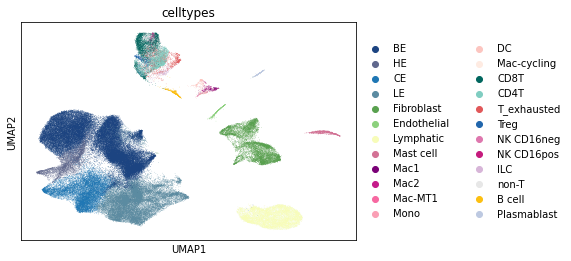

In [8]:
sc.pl.umap(adata, color = 'celltypes', palette = color_dict)

In [14]:
main_dict={'BE':'BE',
    'HE':'HE',
    'CE':'CE',
    'LE':'LE',
    'Fibroblast':'Fibroblast',
    'Endothelial':'Endothelial',
    'Lymphatic':'Lymphatic',
    'Mast cell':'Mast cell',
    'Mac1':'MNP',
    'Mac2':'MNP',
    'Mac-MT1':'MNP',
    'Mono':'MNP',
    'DC':'MNP',
    'Mac-cycling':'MNP',
    'CD8T':'T cell',
    'CD4T':'T cell',
    'T_exhausted':'T cell',
    'Treg':'T cell',
    'NK CD16neg':'NK cell',
    'NK CD16pos':'NK cell',
    'ILC':'ILC',
    'non-T':'non-T',
    'B cell':'B cell',
    'Plasmablast':'Plasmablast',}
cols = {'BE': '#1c4481',
        'HE': '#60688d',
        'CE': '#1f77b4',
        'LE': '#5b8ba1',
        'Fibroblast': '#59a14f',
        'Endothelial': '#8cd17d',
        'Lymphatic':'#f7fcb9',
        'MNP': '#c7233b',
        'Mast cell': '#d37295',
        'NK cell': '#ff9d9a',
        'ILC': '#d7b5d8',
        'T cell': '#f28e2b',
        'B cell': '#fcbf10',
        'Plasmablast': '#bdc9e1',
        'non-T': '#e7e7e7',
       }
adata.obs['celltypes_group'] = [main_dict[l] for l in adata.obs['celltypes']]
adata.obs['celltypes_group'] = adata.obs['celltypes_group'].astype('category')
adata.obs['celltypes_group'] = adata.obs['celltypes_group'].cat.reorder_categories([k for k in cols.keys() if k in list(adata.obs['celltypes_group'])])

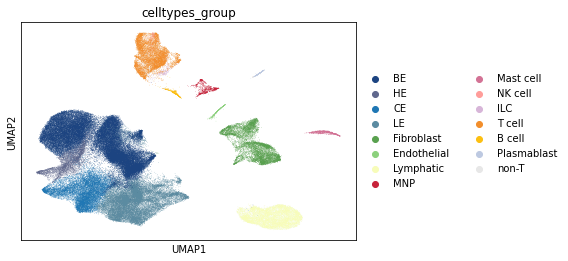

In [15]:
sc.pl.umap(adata, color = 'celltypes_group', palette = cols)

In [16]:
# save
adata.write_h5ad('dataset/Karthaus/karthaus_processed.h5ad', compression = 'gzip')